# Training a Convolutional Neural Network on MNIST
This notebook will demonstrate the convolutional neural network module I created (located in the module `cnn.py`) and benchmark it with PyTorch. 



# Contents
- [Introduction](#Introduction)
- [Import Data](#Import-data)
- [Optimization parameters](#Optimization-parameters)
- [Simple model: training](#Simple-model:-training)
- [Simple model: plots](#Simple-model:-plots)
- [Full model: training](#Full-model:-training)
- [Full model: plots](#Full-model:-plots)
- [Bibliography](#Bibliography)

## Introduction

The original purpose of the module was to reproduce Example 6.3 in [Machine Learning - A First Course for Engineers and Scientists](http://smlbook.org) [[1]](#Bibliography) without dedicated machine learning libraries. The authors consider a 5-layer convolutional neural network applied to the MNIST data set and optimized with the Adam stochastic gradient descent algorithm. The architecture of the network is summarised in the table below:

|                                 |Layer 1|Layer 2|Layer 3|Layer 4|Layer 5|
|---------------------------------|-------|-------|-------|-------|-------|
|Layer type                       | conv  | conv  | conv  |dense  | dense |
|Number of filters/output channels|      4|      8|     12|      -|      -|
|Filter rows and columns          |  (5x5)|  (5x5)|  (4x4)|      -|      -|
|Convolution output image size (pixels)| 28|    14 |    7  |      -|      -|
|Stride                           |      1|      2|      2|      -|      -|
|Number of hidden units           |   3136|   1568|    588|    200|     10|
|Number of parameters  (including bias)            |104    |808    |1548   | 117800|   2010|

The example shows some plots of the loss and error on the training and valdiation datasets which we will also try to recreate. 

Before testing my module on this more complex model, I look at a slightly simpler architecture. 

## Import modules

We first import the necessary modules 

- cnn is my convolutional network module
- trainer contains a class I've written to train a PyTorch model.
- the torch imports are to create the PyTorch model itself and download the MNIST data
- finally, matplotlib is used to plot the losses and errors of the model

In [1]:
import cnn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn.functional as F
import trainer
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

## Import data

Download the MNIST training and testing dataset. These datasets contain 28x28 pixel images of handwritten digits from 0-9. There are 60000 images in the training dataset and 10000 images in the test datset.

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

batch_size = 100
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

### Choose device to run model on

If available, use the metal programming framework for faster computation on GPU. Otherwise, use the CPU.

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to mps")
else:
    device = torch.device("cpu")
    print("Device set to cpu")

Device set to mps


### Copy MNIST data 

Copy MNIST data to numpy array and scale the data (this is done automatically by the PyTorch dataloader). These arrays will be used by my CNN object.

In [4]:
X_np = np.expand_dims(train_data.data.float().clone().detach().numpy(), 1) / 255.0
y_np = train_data.targets.clone().detach().numpy()

test_X_np = np.expand_dims(test_data.data.float().clone().detach().numpy(), 1) / 255.0
test_y_np = test_data.targets.clone().detach().numpy()

## Optimization parameters

### Set PyTorch loss functions
Set the loss functions for the training and test dataset to cross entropy. The loss function in my module is 
not configurable and permanently set as cross entropy.

In [5]:
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction="sum")

### Set model hyperparameters
Set the number of epochs, the learning rate for the Adam optimizers, `test_period` - the number of iterations between tests on the validation dataset.

In [6]:
epochs = 15
lr = 0.001  # learning rate
test_period = 100

## Simple model: training

I first consider a simpler architecture described in the table below

|                                 |Layer 1|Layer 4|Layer 5|
|---------------------------------|-------|-------|-------|
|Layer type                       | conv  |dense  | dense |
|Number of filters/output channels|      2|      -|      -|
|Filter rows and columns          |  (5x5)|      -|      -|
|Convolution output image size (pixels)| 24|      -|      -|
|Stride                           |      1|      -|      -|
|Number of hidden units           |   1152|    200|     10|
|Number of parameters  (including bias)            |52   |230600    |2010|

### PyTorch

A class for this cnn architecture using the PyTorch library is defined in the cell below. 

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 2, 5, padding=0)
        self.fc1 = nn.Linear(2 * 24 * 24, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)  # vectorize
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We create an instance of this class, set the optimizer and create an instance of the training class.

In [8]:
model_simple = ConvNetSimple().to(device)
optimizer_simple = torch.optim.Adam(model_simple.parameters(), lr=lr)
cnn_trainer_simple = trainer.Trainer(
    model_simple,
    device,
    optimizer_simple,
    loss_fn,
    test_loss_fn,
    train_loader,
    test_loader,
    epochs,
    test_period,
)

Now we can train the network:

In [9]:
%%timeit -n 1 -r 1
cnn_trainer_simple.train()

Epoch 1 of 15: loss = 0.296
Epoch 2 of 15: loss = 0.100
Epoch 3 of 15: loss = 0.070
Epoch 4 of 15: loss = 0.054
Epoch 5 of 15: loss = 0.043
Epoch 6 of 15: loss = 0.033
Epoch 7 of 15: loss = 0.027
Epoch 8 of 15: loss = 0.021
Epoch 9 of 15: loss = 0.019
Epoch 10 of 15: loss = 0.015
Epoch 11 of 15: loss = 0.012
Epoch 12 of 15: loss = 0.009
Epoch 13 of 15: loss = 0.008
Epoch 14 of 15: loss = 0.008
Epoch 15 of 15: loss = 0.008
2min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### My module

We create the neural network object and the individual layer objects that make up the CNN, then add these layers to the network.

In [13]:
layer_simple0 = cnn.ConvLayer(channels_in=1, channels_out=2, dim_in=28,
                              dim_out=24, dim_W=5, stride=1, eta = lr)
layer_simple1 = cnn.VeccingLayer(channels_in=2, dim_in=24)
layer_simple2 = cnn.DenseLayer(dim_in=2 * 24 * 24, dim_out=200, eta = lr)
layer_simple3 = cnn.SoftmaxLayer(dim_in=200, dim_out=10, eta = lr)
my_cnn_simple = cnn.Neural(epochs=epochs, num_classes=10)
my_cnn_simple.add_layer(layer_simple0)
my_cnn_simple.add_layer(layer_simple1)
my_cnn_simple.add_layer(layer_simple2)
my_cnn_simple.add_layer(layer_simple3)

Train the network on the MNIST data:

In [14]:
%%timeit -n 1 -r 1
my_cnn_simple.fit(
    X_np,
    y_np,
    batch_size=batch_size,
    test_X=test_X_np,
    test_y=test_y_np,
    test_period=test_period,
)

Epoch 0 of 15: loss = 0.300
Epoch 1 of 15: loss = 0.124
Epoch 2 of 15: loss = 0.084
Epoch 3 of 15: loss = 0.063
Epoch 4 of 15: loss = 0.050
Epoch 5 of 15: loss = 0.041
Epoch 6 of 15: loss = 0.034
Epoch 7 of 15: loss = 0.028
Epoch 8 of 15: loss = 0.022
Epoch 9 of 15: loss = 0.019
Epoch 10 of 15: loss = 0.016
Epoch 11 of 15: loss = 0.013
Epoch 12 of 15: loss = 0.013
Epoch 13 of 15: loss = 0.011
Epoch 14 of 15: loss = 0.010
6min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Simple model: plots

I define a helper function to take the moving average of an array. This smooths out the fluctuations in the optimisation process so the behaviour of the loss and error is clearer.

In [15]:
def moving_average(array, w=3):
    psum = np.cumsum(array, dtype=float)
    psum[w:] = psum[w:] - psum[:-w]
    return psum[w - 1 :] / w

### Loss

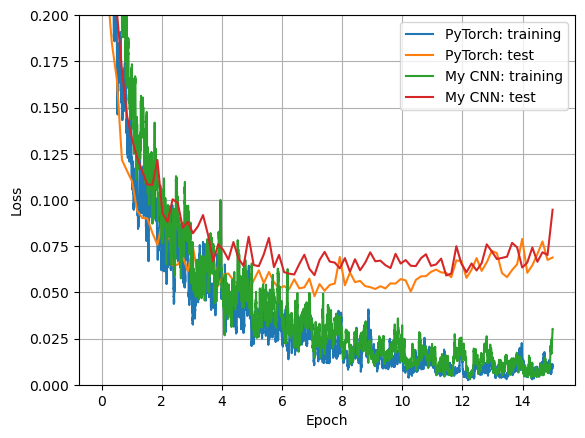

In [16]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

w = 20 # iteration window size of moving average
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer_simple.losses) - w + 1),
    moving_average(cnn_trainer_simple.losses, w),
    label="PyTorch: training",
)
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer_simple.test_losses)),
    cnn_trainer_simple.test_losses,
    label="PyTorch: test",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.costs) - w + 1),
    moving_average(my_cnn_simple.costs, w),
    label="My CNN: training",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.test_costs)),
    my_cnn_simple.test_costs,
    label="My CNN: test",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 0.2)
plt.grid()
plt.legend()
plt.show()

### Error

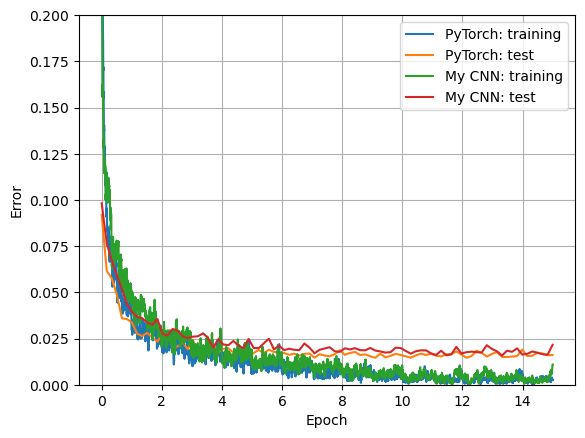

In [17]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

w = 20  # iteration window size of moving average
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer_simple.errors) - w + 1),
    moving_average(cnn_trainer_simple.errors, w),
    label="PyTorch: training",
)
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer_simple.test_errors)),
    cnn_trainer_simple.test_errors,
    label="PyTorch: test",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.errors) - w + 1),
    moving_average(my_cnn_simple.errors, w),
    label="My CNN: training",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.test_errors)),
    my_cnn_simple.test_errors,
    label="My CNN: test",
)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

## Full model: training

Now we repeat the previous steps on the more complex model described in the introduction.

### PyTorch

Again we define a class for the PyTorch model, this time according to the architecture shown in the table in the introduction. The required amount of padding for the cross-correlation operation on the input to layer $l$ is

$$p^{(l)}_\rightarrow = s_l(h^{(l)}_\text{out}-1)+f_l - h^{(l)}_\text{in},$$

where $f_l$ is the filter's width and height (in pixels) , $s_l$ is the stride, and $h_{\text{in (out)}}^{(l)}$ is the height and width of the input (output) image to layer $l$.

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, padding=2)
        self.conv2 = nn.Conv2d(2, 4, 5, stride=2)
        self.conv3 = nn.Conv2d(4, 8, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 200)
        # self.conv3 = nn.Conv2d(4, 8, 4, stride=2, padding=3)
        # self.fc1 = nn.Linear(8 * 9 * 9, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # the architecture requires uneven padding on left to
        # right and top to bottom of image.
        x = F.pad(x, (2, 1, 2, 1))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
cnn_trainer = trainer.Trainer(
    model,
    device,
    optimizer,
    loss_fn,
    test_loss_fn,
    train_loader,
    test_loader,
    epochs,
    test_period,
)

In [23]:
%%timeit -n 1 -r 1
cnn_trainer.train()

Epoch 1 of 15: loss = 0.453
Epoch 2 of 15: loss = 0.115
Epoch 3 of 15: loss = 0.080
Epoch 4 of 15: loss = 0.063
Epoch 5 of 15: loss = 0.050
Epoch 6 of 15: loss = 0.044
Epoch 7 of 15: loss = 0.036
Epoch 8 of 15: loss = 0.031
Epoch 9 of 15: loss = 0.026
Epoch 10 of 15: loss = 0.023
Epoch 11 of 15: loss = 0.019
Epoch 12 of 15: loss = 0.017
Epoch 13 of 15: loss = 0.016
Epoch 14 of 15: loss = 0.014
Epoch 15 of 15: loss = 0.012
2min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### My module


In [32]:
layer0 = cnn.ConvLayer(channels_in=1, channels_out=2, dim_in=28,
                       dim_out=28, dim_W=5, stride=1, eta=lr)
layer1 = cnn.ConvLayer(channels_in=2, channels_out=4, dim_in=28,
                       dim_out=14, dim_W=5, stride=2, eta=lr)
layer2 = cnn.ConvLayer(channels_in=4, channels_out=8, dim_in=14,
                       dim_out=7, dim_W=4, stride=2, eta=lr)
layer3 = cnn.VeccingLayer(channels_in=8, dim_in=7)
layer4 = cnn.DenseLayer(dim_in=8 * 7 * 7, dim_out=200, eta=lr)
layer5 = cnn.SoftmaxLayer(dim_in=200, dim_out=10, eta=lr)
my_cnn = cnn.Neural(epochs=epochs, num_classes=10)
my_cnn.add_layer(layer0)
my_cnn.add_layer(layer1)
my_cnn.add_layer(layer2)
my_cnn.add_layer(layer3)
my_cnn.add_layer(layer4)
my_cnn.add_layer(layer5)

In [31]:
epochs

15

In [33]:
%%timeit -n 1 -r 1
my_cnn.fit(
    X_np, y_np, batch_size=100, test_X=test_X_np, test_y=test_y_np, test_period=100
)

Epoch 0 of 15: loss = 0.320
Epoch 1 of 15: loss = 0.095
Epoch 2 of 15: loss = 0.068
Epoch 3 of 15: loss = 0.054
Epoch 4 of 15: loss = 0.045
Epoch 5 of 15: loss = 0.036
Epoch 6 of 15: loss = 0.031
Epoch 7 of 15: loss = 0.027
Epoch 8 of 15: loss = 0.022
Epoch 9 of 15: loss = 0.022
Epoch 10 of 15: loss = 0.018
Epoch 11 of 15: loss = 0.014
Epoch 12 of 15: loss = 0.013
Epoch 13 of 15: loss = 0.013
Epoch 14 of 15: loss = 0.013
22min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Full model: plots

### Loss

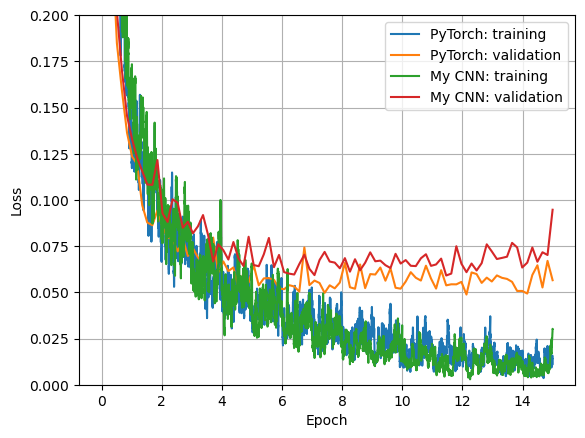

In [47]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# iteration window size of moving average
w = 20
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer.losses) - w + 1),
    moving_average(cnn_trainer.losses, w),
    label="PyTorch: training",
)
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer.test_losses)),
    cnn_trainer.test_losses,
    label="PyTorch: validation",
)

plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.costs)-w+1),
    moving_average(my_cnn_simple.costs, w),
    label="My CNN: training",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.test_costs)),
    my_cnn_simple.test_costs,
    label="My CNN: validation",
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 0.2)
plt.grid()
plt.legend()
plt.show()
#plt.savefig("loss.pdf")

### Error

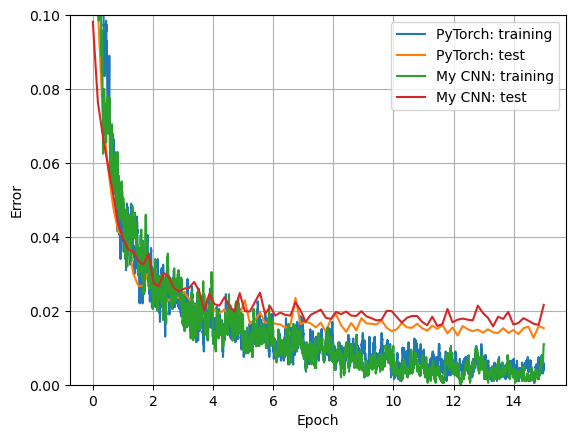

In [46]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

w = 20 # iteration window size of moving average
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer.errors) - w + 1),
    moving_average(cnn_trainer.errors, w),
    label="PyTorch: training",
)
plt.plot(
    np.linspace(0, epochs, len(cnn_trainer.test_errors)),
    cnn_trainer.test_errors,
    label="PyTorch: test",
)

plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.errors)-w+1),
    moving_average(my_cnn_simple.errors, w),
    label="My CNN: training",
)
plt.plot(
    np.linspace(0, epochs, len(my_cnn_simple.test_errors)),
    my_cnn_simple.test_errors,
    label="My CNN: test",
)

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()
#plt.savefig("error.pdf")

## Bibliography

[1] Lindholm, A., Wahlström, N., Lindsten, F., & Schön, T. B. (2022). Machine learning—A first course for engineers and scientists. Cambridge University Press. https://smlbook.org
